# Table of Contents
- Hypothesis Testing in Python
- Two Sample Hypothesis Tests with Scipy
- Independent Samples
- Matched Pairs
- More Hypothesis Testing with SciPy and Stats Models
- ANOVA in Python
- Chi square

In [169]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8,8)

# Hypothesis Testing in Python

We can use the Scipy library to perform hypothesis tests. The Scipy library has a function for one sample hypothesis tests called ttest_1samp. This test takes a dataset and a constant for comparison and returns the test statistic and the p value for a 2 sided test.



In [172]:
patients = stats.norm(5.1, 1.6).rvs(100)
np.mean(patients)

5.300943795997673

In [173]:
stats.sem(patients)

0.1676611455268958

In this example, we generated random data with mean 5.1 and standard deviation 1.6 in order to simulate our patients. Imagine that we want to check if our sample supports an initial assumtion that the mean is 5.7. 

In [183]:
stats.ttest_1samp(patients, 5.7)

Ttest_1sampResult(statistic=-2.3801352588176803, pvalue=0.019221334843046767)

With a p-value much smaller than the usual limit of 0.05 we reject the null hypothesis.

Note: This is a one-sided test so we will only look at the test statistic. In order to use the p-value we have to divide the p-value by 2.

An alternative approach is to calculate the z_value

In [184]:
z_value = (np.mean(patients)- 5.7)/stats.sem(patients)
print(z_value)

-2.3801352588176803


and then calculate the p-value from the t-distribution

In [182]:
p_val = stats.t(99).sf(z_value)
print(p_val)

0.009610667421523384


# Two Sample Hypothesis Tests

## Independent Samples

The following is an example of a 2 sample hypothesis test with equal variance. We will load a sample dataset of transaction amounts from an e-commerce website. The dataset ab_test.csv can be downloaded here.

https://s3-eu-west-1.amazonaws.com/ih-materials/uploads/data-static/data/module-2/ab_test.csv

In [185]:
ab_test = pd.read_csv('data/ab_test.csv')
ab_test.head()

,a,b
0,0.27,13.61
1,6.08,21.53
2,13.74,9.23
3,9.70,5.36
4,7.00,12.90


We make the assumption that the variances of both populations are equal based on prior knowledge of the data. Now we will test that there is a significant difference between the website layouts with a 95% degree of confidence.

In [187]:
ab_test.describe()

,a,b
count,50.00000,50.000000
mean,9.35540,12.466000
std,5.23527,6.491255
min,0.27000,0.590000
25%,5.42000,8.112500
50%,9.07000,12.635000
75%,13.46000,17.850000
max,20.90000,24.000000


In [186]:
stats.ttest_ind(ab_test.a, ab_test.b)

Ttest_indResult(statistic=-2.637533181209767, pvalue=0.009713140852447347)

Our p-value is very small. This means that there is a significant difference between the two sample means.

Let's use our A/B test data to perform a t-test that does not require the equal variance assumption:

In [188]:
stats.ttest_ind(ab_test.a, ab_test.b, equal_var=False)

Ttest_indResult(statistic=-2.637533181209767, pvalue=0.009776243024828825)

In this case the p-value slightly differs from the one we get with equal variances. However, since it is very small in this case as well, we will still reject the null hypothesis and conclude that there is a significant difference between the two sample means.

## Matched Pairs

Let's start by looking at our dataset. The file blood_pressure.csv can be downloaded here.

https://s3-eu-west-1.amazonaws.com/ih-materials/uploads/data-static/data/module-2/blood_pressure.csv

In [189]:
import pandas as pd

blood_pressure = pd.read_csv('data/blood_pressure.csv')
blood_pressure.head()

,before,after
0,136.713072,92.432965
1,134.735618,105.022643
2,127.529115,82.242766
3,144.527126,93.607172
4,124.214720,103.212223


In [190]:
blood_pressure.describe()

,before,after
count,100.000000,100.000000
mean,136.536953,99.236700
std,10.189314,9.060200
min,115.033831,74.009544
25%,129.054274,93.117525
50%,136.734185,99.235306
75%,144.625304,106.303905
max,161.566769,119.103335


We will be using the scipy function ttest_rel. This function is used for hypothesis testing of dependent data.

In [191]:
stats.ttest_rel(blood_pressure.after, blood_pressure.before)

Ttest_relResult(statistic=-27.291841767560236, pvalue=7.303035069608042e-48)

Our result is a very small p-value. This means that we will reject the null hypothesis.

Since a matched pairs test is equivalent to a one sample test of the difference, we can also perform a one sample test and get the exact same result.

In [192]:
stats.ttest_1samp(blood_pressure.after-blood_pressure.before, 0)

Ttest_1sampResult(statistic=-27.291841767560236, pvalue=7.303035069608042e-48)

We can see that the p-value is identical since the tests are equivalent.

## ANOVA

Below is an example of a dataset containing 8 observations of car loan interest rates from 6 different cities. We would like to show that there is a difference in the rates based on city. The dataset rate_by_city.csv can be obtained here.

https://s3-eu-west-1.amazonaws.com/ih-materials/uploads/data-static/data/module-2/rate_by_city.csv

In [194]:
import pandas as pd
from scipy.stats import f_oneway

#let's load the dataset
rate = pd.read_csv('data/rate_by_city.csv')
rate.head(15)

,Rate,City
0,13.75,1
1,13.75,1
2,13.50,1
3,13.50,1
4,13.00,1
5,13.00,1
6,13.00,1
7,12.75,1
8,12.50,1
9,14.25,2


The dataset contains two columns - rate and city. To test our hypothesis, we need to either pass in multiple filtered subsets to our function or to pivot the dataset to have one column per city. We'll choose the second option. We'll start off by using the cumcount function to create a new index and then use the pivot function to create 6 city columns. We will then rename the columns to allow us to access them more easily.

In [54]:
rate['city_count'] = rate.groupby('City').cumcount()
rate_pivot = rate.pivot(index='city_count', columns='City', values='Rate')
rate_pivot.columns = ['City_'+str(x) for x in rate_pivot.columns.values]
rate_pivot.head()

,City_1,City_2,City_3,City_4,City_5,City_6
city_count,,,,,,
0,13.75,14.25,14.00,15.00,14.50,13.50
1,13.75,13.00,14.00,14.00,14.00,12.25
2,13.50,12.75,13.51,13.75,14.00,12.25
3,13.50,12.50,13.50,13.59,13.90,12.00
4,13.00,12.50,13.50,13.25,13.75,12.00


Now that we have successfully pivoted the data, we can perform the test. The f_oneway function requires us to specify each column that is passed into the function (rather than passing the entire dataframe)

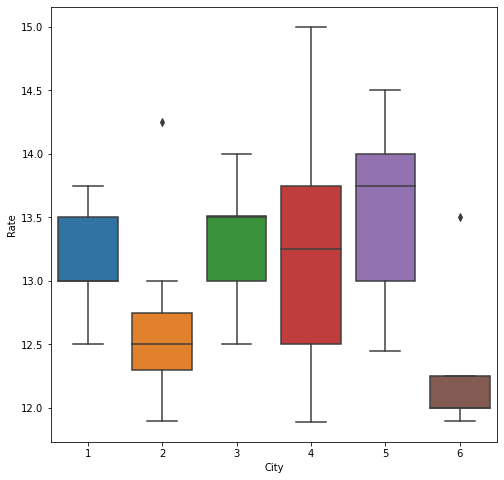

In [198]:
sns.boxplot(rate.City, rate.Rate)

In [196]:
rate_pivot.mean()

City_1    13.194444
City_2    12.611111
City_3    13.306667
City_4    13.244444
City_5    13.483333
City_6    12.200000
dtype: float64

In [197]:
f_oneway(rate_pivot.City_1,rate_pivot.City_2,rate_pivot.City_3,rate_pivot.City_4,rate_pivot.City_5,rate_pivot.City_6)

F_onewayResult(statistic=0.2917176570124943, pvalue=0.8310497964741945)

The p-value is 0.001174. This value is very small, certainly smaller than 0.05. Therefore, we reject the null hypothesis and conclude that the rates differ by city.

# U Mann Whitney test

In [199]:
prices = pd.read_csv('data/airbnb.csv')

In [201]:
prices.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia And Maria,Eixample,la Sagrada Família,41.40420,2.17306,Entire home/apt,85,1,21,2019-11-01,0.26,24,258
1,23197,Forum DeLuxe 5 mins Walk To CCIB Center & Sea★,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41291,2.22063,Entire home/apt,220,3,52,2019-12-15,0.48,4,347
2,25786,NICE ROOM AVAILABLE IN THE HEART OF GRACIA,108310,Pedro,Gràcia,la Vila de Gràcia,41.40145,2.15645,Private room,32,1,269,2019-11-14,2.32,1,122
3,31958,"Gaudi Attic 1, Friendly Rentals",136853,Fidelio,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40950,2.15938,Entire home/apt,58,1,187,2020-01-07,1.71,29,262
4,32471,"Gaudi Attic 2, Friendly Rentals",136853,Fidelio,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40928,2.16112,Entire home/apt,63,1,91,2019-11-05,0.82,29,274


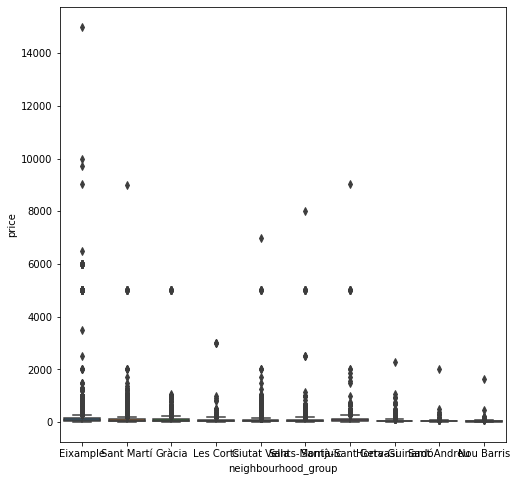

In [202]:
sns.boxplot(x=prices.neighbourhood_group, y=prices.price)

In [203]:
precios = prices.get(prices.price < 500)

In [204]:
precios.neighbourhood_group.value_counts()

Eixample               6663
Ciutat Vella           4921
Sants-Montjuïc         2421
Sant Martí             2134
Gràcia                 1695
Sarrià-Sant Gervasi     750
Horta-Guinardó          661
Les Corts               436
Sant Andreu             357
Nou Barris              278
Name: neighbourhood_group, dtype: int64

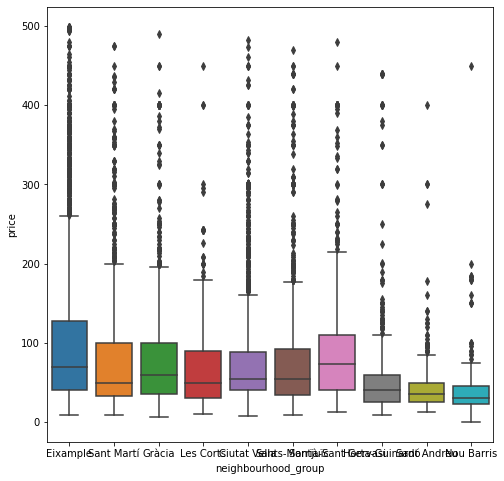

In [205]:
sns.boxplot(x=precios.neighbourhood_group, y=precios.price)

In [79]:
precios.query('neighbourhood_group in ["Eixample", "Ciutat Vella"]')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia And Maria,Eixample,la Sagrada Família,41.404200,2.173060,Entire home/apt,85,1,21,2019-11-01,0.26,24,258
7,34241,Private Double room - Plaza Real,73163,Andres,Ciutat Vella,el Barri Gòtic,41.379160,2.175350,Private room,100,5,8,2013-07-15,0.07,2,167
8,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.379780,2.176230,Entire home/apt,350,5,146,2020-01-12,1.28,2,241
9,35379,Double 02 CasanovaRooms Barcelona,152232,Pablo,Eixample,l'Antiga Esquerra de l'Eixample,41.390360,2.152740,Private room,40,2,297,2020-02-11,3.08,3,237
10,35390,Single 02 CasanovaRooms Barcelona,152232,Pablo,Eixample,l'Antiga Esquerra de l'Eixample,41.391530,2.151250,Private room,30,2,253,2020-02-15,2.68,3,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20971,42310008,Explore Barcelona‘s center through this flat!,335586534,Ivan,Ciutat Vella,el Barri Gòtic,41.384756,2.173150,Entire home/apt,160,2,0,NaN,NaN,6,90
20974,42314600,Habitación Estilo (Loft) Cerca deTeatro Liceu,32030896,Dani,Ciutat Vella,el Raval,41.377150,2.169890,Entire home/apt,90,1,0,NaN,NaN,2,321
20976,42319864,Room near the beach ☀️,336344751,María,Ciutat Vella,la Barceloneta,41.378584,2.191273,Private room,30,1,0,NaN,NaN,1,13
20979,42320286,Cozy apartment (downtown of Barcelona),183514245,Manrique,Eixample,la Nova Esquerra de l'Eixample,41.381451,2.155175,Entire home/apt,148,1,0,NaN,NaN,1,332


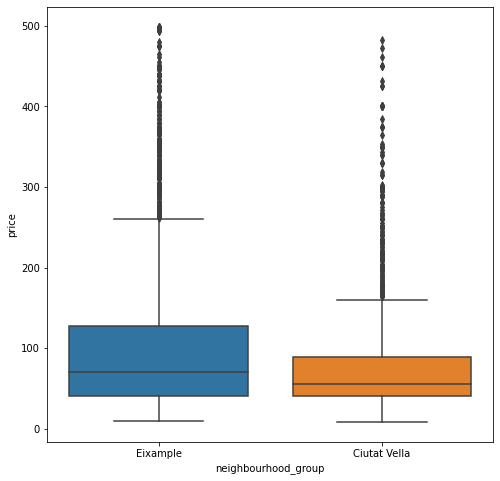

In [206]:
sns.boxplot(x='neighbourhood_group', y='price', data=precios.query('neighbourhood_group in ["Eixample", "Ciutat Vella"]'))

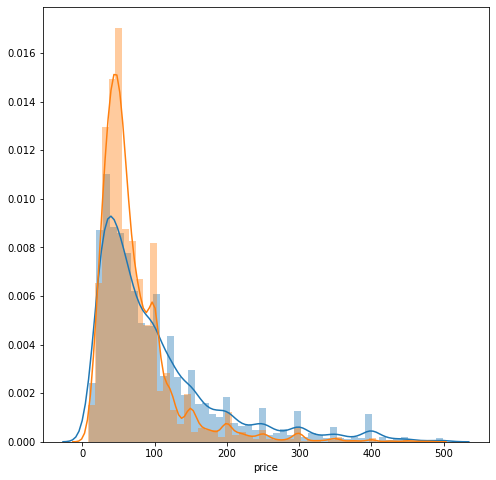

In [207]:
sns.distplot(precios.query('neighbourhood_group == "Eixample"').price)
sns.distplot(precios.query('neighbourhood_group == "Ciutat Vella"').price)

In [209]:
data1 = precios.query('neighbourhood_group == "Eixample"').price
data2 = precios.query('neighbourhood_group == "Ciutat Vella"').price
                    
u, p = stats.mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.10f' % (u, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=13569581.000, p=0.0000000000
Different distribution (reject H0)


In [210]:
stats.ttest_ind(data1, data2)

Ttest_indResult(statistic=20.499853526497752, pvalue=9.091508943841636e-92)

# Wilcoxon test 

In [211]:
blood_pressure.head()

,before,after
0,136.713072,92.432965
1,134.735618,105.022643
2,127.529115,82.242766
3,144.527126,93.607172
4,124.214720,103.212223


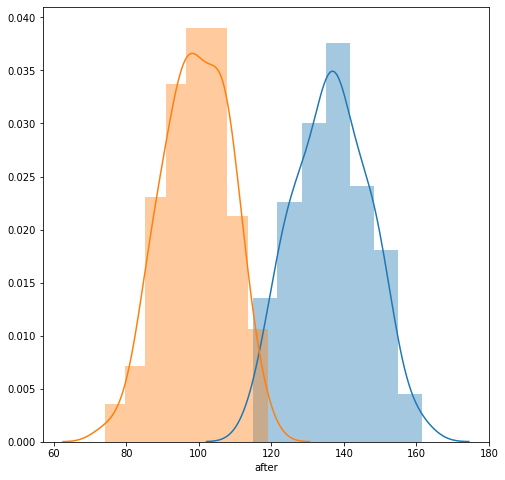

In [212]:
sns.distplot(blood_pressure.before)
sns.distplot(blood_pressure.after)

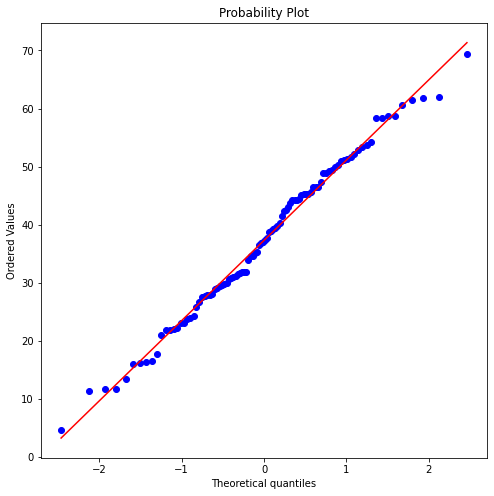

In [213]:
_=stats.probplot(blood_pressure.before -blood_pressure.after, plot= plt)

In [214]:
stats.wilcoxon(blood_pressure.before, blood_pressure.after)

WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)

# Kruskal-Wallis H-test

In [216]:

from numpy.random import seed
from numpy.random import randn
from scipy.stats import kruskal
# seed the random number generator
seed(1)
# generate three independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 50
data3 = 5 * randn(100) + 52
# compare samples
stat, p = kruskal(data1, data2, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=6.051, p=0.049
Different distributions (reject H0)


# Friedman test

In [219]:

from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare
# seed the random number generator
seed(1)
# generate three independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 50
data3 = 5 * randn(100) + 52
# compare samples
stat, p = friedmanchisquare(data1, data2, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=9.360, p=0.009
Different distributions (reject H0)


# Chi square

In [220]:
extranjeros = pd.DataFrame(index=['argentinian','french','italian','russian'], 
                           data=dict(spain=[60000, 50000, 100000, 65000], 
                                     barcelona=[5500, 5500, 9500, 9500 ]))

In [221]:
extranjeros.head()

,spain,barcelona
argentinian,60000,5500
french,50000,5500
italian,100000,9500
russian,65000,9500


In [222]:
stats.chisquare(f_obs= observed,   # Array of observed counts
                f_exp= expected)   # Array of expected counts

Power_divergenceResult(statistic=1167.8418803418804, pvalue=6.956027681517176e-253)

In [223]:
observed = extranjeros.barcelona

national_ratios = extranjeros.spain/extranjeros.spain.sum()  # Get population ratios

expected = national_ratios * extranjeros.barcelona.sum()   # Get expected counts

chi_squared_stat = (((observed-expected)**2)/expected).sum()

print(chi_squared_stat)

1167.8418803418804


In [224]:
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 3)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=3)
print("P value")
print(p_value)

Critical value
7.814727903251179
P value
0.0
